# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Deep Learning. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
from __future__ import print_function, division

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings
warnings.filterwarnings('ignore')

plt.ion()   # interactive mode

In [ ]:
pic = plt.imread('images/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [ ]:
pic = np.transpose(pic, axes=(1, 0, 2))

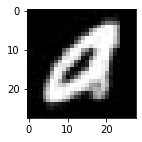

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

##### Переворачиваем картинки (еще раз запустить - перевернутся обратно)

In [ ]:
from PIL import Image
import glob

for pic_name in glob.glob('images/*/*/*.jpg'):
    im = Image.open(pic_name)
    im = Image.fromarray(np.transpose(im, axes=(1, 0, 2)))
    im.save(pic_name)

## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

In [ ]:
!unzip images.zip

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}

data_dir = 'images/' 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 1.1

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(784, 150).to(device)
        self.fc2 = nn.Linear(150, 100).to(device)
        self.fc3 = nn.Linear(100, 70).to(device)
        self.fc4 = nn.Linear(70, 26).to(device)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(784, 128).to(device)
        self.fc2 = nn.Linear(128, 64).to(device)
        self.fc3 = nn.Linear(64, 26).to(device)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
net1 = Net1()
net1.to(device)
net2 = Net2().to(device)
net2.to(device)

Net2(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=26, bias=True)
)

In [6]:
optimizer_1 = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9, weight_decay=4e-3)

scheduler_1 = lr_scheduler.StepLR(optimizer_1, step_size=7, gamma=0.1)

optimizer_2 = optim.ASGD(net2.parameters(), lr=0.004)

scheduler_2 = lr_scheduler.StepLR(optimizer_2, step_size=7, gamma=0.1)

In [22]:
def train_model_1(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = (inputs.view(inputs.shape[0], -1)).to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [341]:
model1 = train_model_1(net1, nn.CrossEntropyLoss(), optimizer_1, scheduler_1, 1)

Epoch 0/0
----------
train Loss: 1.1712 Acc: 0.6436
test Loss: 0.6697 Acc: 0.7888

Training complete in 1m 30s
Best test Acc: 0.788846


In [214]:
model2 = train_model_1(net2, nn.CrossEntropyLoss(), optimizer_2, scheduler_2, 1)

Epoch 0/0
----------
train Loss: 0.4818 Acc: 0.8481
test Loss: 0.4503 Acc: 0.8576

Training complete in 1m 23s
Best test Acc: 0.857615


In [217]:
PATH = './letters_net.pth'
torch.save(model2.state_dict(), PATH)

### 1.2

In [187]:
nb_classes = 26
batch_lst = [0 for i in range(len(dataloaders['test']))]

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):      
        batch_lst[i] = [inputs,]

        inputs = (inputs.view(inputs.shape[0], -1)).to(device)
        classes = classes.to(device)
        outputs = model1(inputs)
        _, preds = torch.max(outputs, 1)

        batch_lst[i] += [preds, classes]

        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

cm = confusion_matrix

In [183]:
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.numpy().astype('float')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

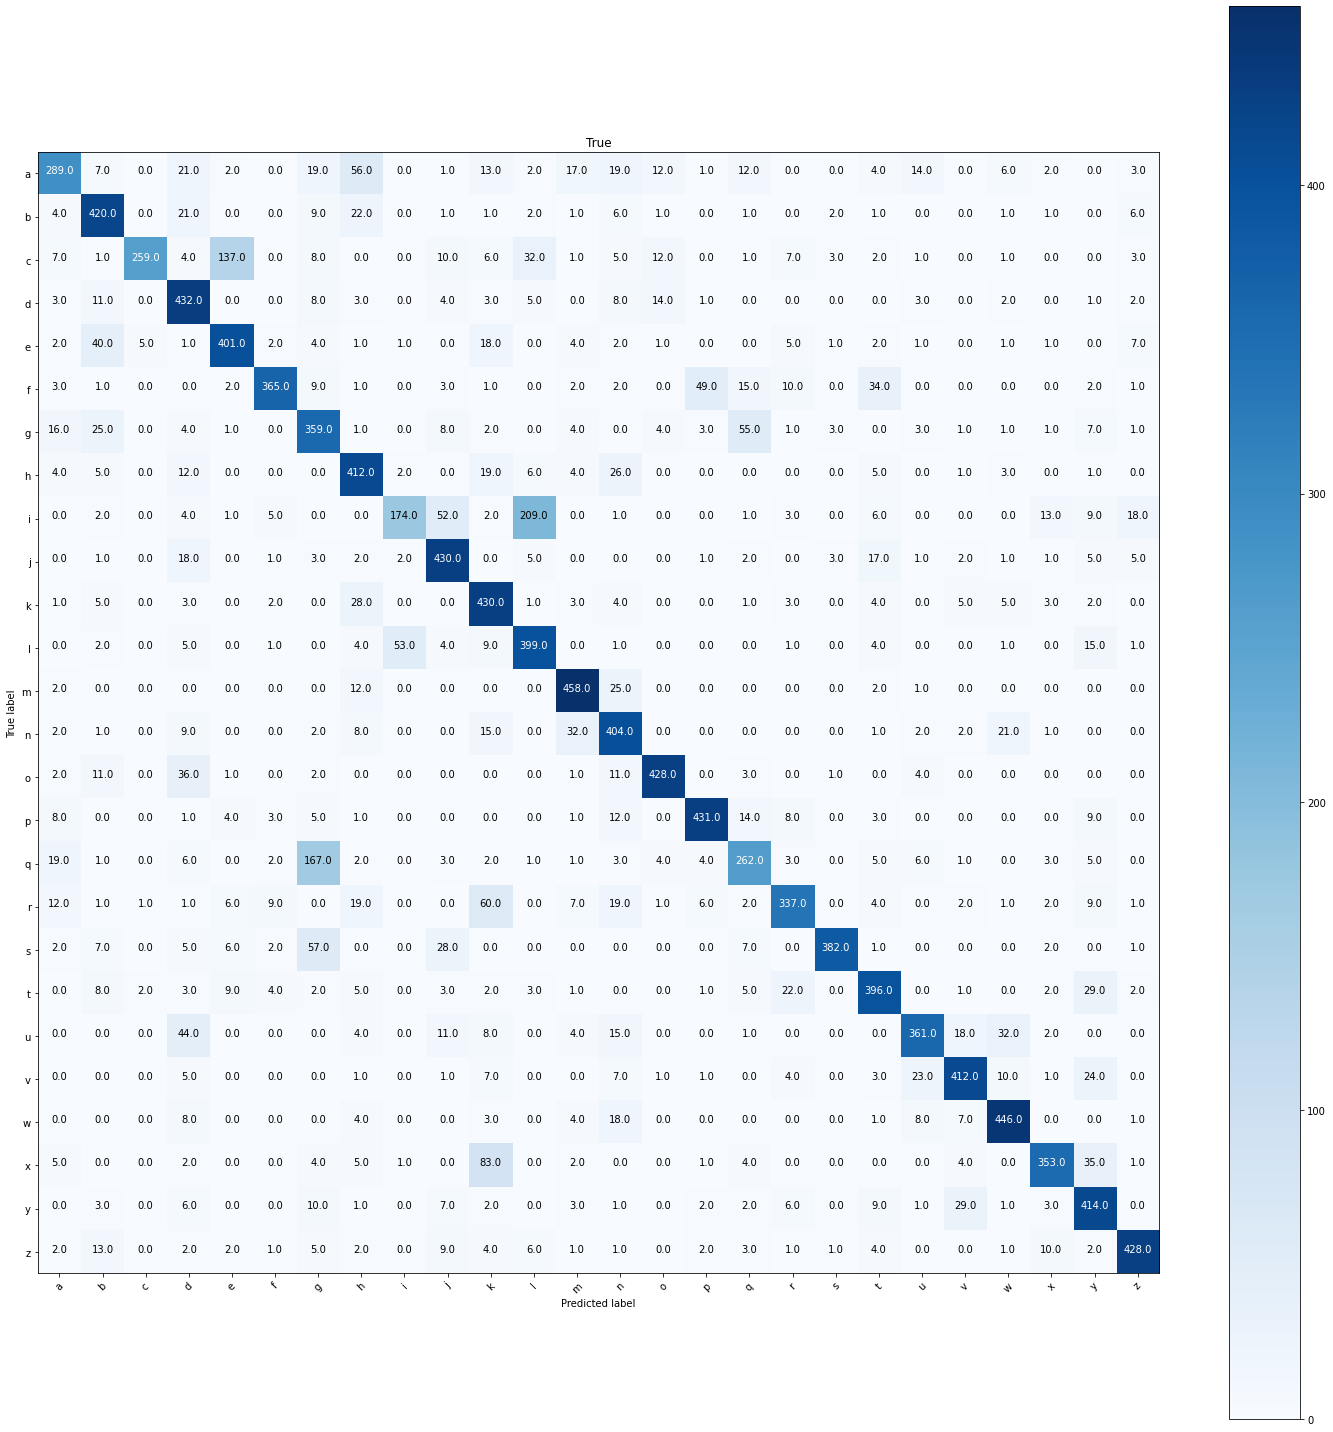

In [132]:
plt.figure(figsize=(20, 20))
plot_confusion_matrix(cm, class_names, True)

In [105]:
res_conf = {cls: int(cm[i][i]) for i, cls in enumerate(class_names)}

In [102]:
print(f'The best accuracy: "{min(res_conf, key=res_conf.get)}"')
print(f'The worst accuracy: "{max(res_conf, key=res_conf.get)}"')

The best accuracy: "r"
The worst accuracy: "c"


### 1.3

In [125]:
from itertools import combinations

pairs = dict.fromkeys(map(frozenset, combinations(class_names, 2)), 0)
for i, cls1 in enumerate(class_names):
    for j, cls2 in enumerate(class_names):
        if cls1 == cls2:
            continue
    pairs[frozenset([cls1, cls2])] += int(cm[i][j])

top_10_conf = list(pairs.items())
top_10_conf.sort(key=lambda i: i[1], reverse=True)

In [128]:
print(f'Pairs confused most often:', [el[0] for el in top_10_conf][:10])

Pairs confused most often: [frozenset({'i', 'l'}), frozenset({'q', 'g'}), frozenset({'r', 't'}), frozenset({'e', 'c'}), frozenset({'u', 'v'}), frozenset({'o', 'd'}), frozenset({'d', 'b'}), frozenset({'n', 'm'}), frozenset({'s', 'g'}), frozenset({'h', 'b'})]


Вывод тривиальный, путаются чаще всего буквы, похожие друг на друга

In [200]:
cls_idx = image_datasets['train'].class_to_idx
cls_idx

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

In [195]:
def imshow(img, pred, cls):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'{class_names[pred]} recognized as {class_names[cls]}')
    plt.show()

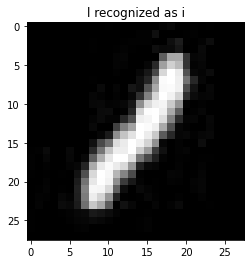

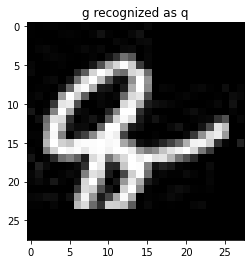

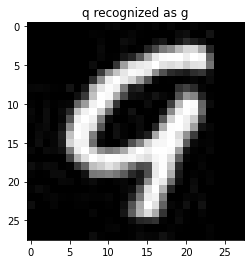

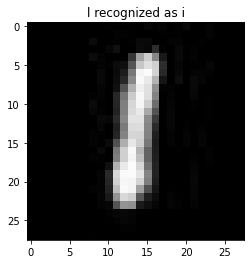

In [196]:
for img_batch in batch_lst[:20]:
    for img, pred, lab in zip(img_batch[0], img_batch[1].to('cpu').numpy(), img_batch[2].to('cpu').numpy()):
        if (int(pred) == 8 and int(lab) == 11) or (int(pred) == 11 and int(lab) == 8) or (int(pred) == 6 and int(lab) == 16) or (int(pred) == 16 and int(lab) == 6):
            imshow(img, pred, lab)

### 1.4

In [212]:
ind = cls_idx['e']
print(f'"e" percision is {int(cm[4][4]) / 500}')

"e" percision is 0.802


In [199]:
print('From most often confused to leat often confused:')
for el in top_10_conf:
    if 'e' in el[0]:
        print(el)

From most often confused to leat often confused:
(frozenset({'e', 'c'}), 86)
(frozenset({'e', 'r'}), 20)
(frozenset({'e', 'a'}), 17)
(frozenset({'e', 't'}), 9)
(frozenset({'e', 'z'}), 7)
(frozenset({'e', 'b'}), 6)
(frozenset({'e', 's'}), 6)
(frozenset({'e', 'f'}), 5)
(frozenset({'e', 'o'}), 5)
(frozenset({'e', 'k'}), 4)
(frozenset({'e', 'g'}), 3)
(frozenset({'e', 'p'}), 3)
(frozenset({'e', 'q'}), 3)
(frozenset({'e', 'u'}), 2)
(frozenset({'e', 'v'}), 2)
(frozenset({'e', 'w'}), 2)
(frozenset({'e', 'y'}), 2)
(frozenset({'e', 'i'}), 1)
(frozenset({'e', 'm'}), 1)
(frozenset({'e', 'n'}), 1)
(frozenset({'e', 'd'}), 0)
(frozenset({'e', 'h'}), 0)
(frozenset({'e', 'j'}), 0)
(frozenset({'e', 'l'}), 0)
(frozenset({'e', 'x'}), 0)


### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

### 2.1

In [395]:
class Net_conv_1(nn.Module):
    def __init__(self):
        super(Net_conv_1, self).__init__()
        self.conv = nn.Conv2d(1, 3, 5).to(device)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3 * 12 * 12, 128).to(device)
        self.fc2 = nn.Linear(128, 64).to(device)
        self.fc3 = nn.Linear(64, 26).to(device)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = x.view(-1, 3 * 12 * 12).to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Net_conv_2(nn.Module):
    def __init__(self):
        super(Net_conv_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 3).to(device)
        self.conv2 = nn.Conv2d(12, 8, 3).to(device)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 5 * 5, 128).to(device)
        self.fc2 = nn.Linear(128, 64).to(device)
        self.fc3 = nn.Linear(64, 26).to(device)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 5 * 5).to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Net_conv_3(nn.Module):
    def __init__(self):
        super(Net_conv_3, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3).to(device)
        self.conv2 = nn.Conv2d(10, 7, 3).to(device)
        self.conv3 = nn.Conv2d(7, 4, 2).to(device)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4 * 11 * 11, 128).to(device)
        self.fc2 = nn.Linear(128, 64).to(device)
        self.fc3 = nn.Linear(64, 26).to(device)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 4 * 11 * 11).to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [396]:
net_conv1 = Net_conv_1()
net_conv1.to(device)
net_conv2 = Net_conv_2()
net_conv2.to(device)
net_conv3 = Net_conv_3()
net_conv3.to(device)

Net_conv_3(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 7, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(7, 4, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=484, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=26, bias=True)
)

In [2]:
def train_model_2(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [369]:
optimizer_cov1 = optim.ASGD(net_conv1.parameters(), lr=0.004)

scheduler_cov2 = lr_scheduler.StepLR(optimizer_cov1, step_size=7, gamma=0.1)

In [368]:
model_conv1 = train_model_2(net_conv1, nn.CrossEntropyLoss(), optimizer_cov1, scheduler_cov2, 1)

Epoch 0/0
----------
train Loss: 1.1278 Acc: 0.6594
test Loss: 0.5476 Acc: 0.8301

Training complete in 1m 35s
Best test Acc: 0.830077


In [406]:
optimizer_cov2 = optim.ASGD(net_conv2.parameters(), lr=0.004)

scheduler_cov2 = lr_scheduler.StepLR(optimizer_cov2, step_size=7, gamma=0.1)

In [407]:
model_conv2 = train_model_2(net_conv2, nn.CrossEntropyLoss(), optimizer_cov2, scheduler_cov2, 1)

Epoch 0/0
----------
train Loss: 2.6265 Acc: 0.2352
test Loss: 1.1942 Acc: 0.6285

Training complete in 0m 52s
Best test Acc: 0.628538


In [399]:
optimizer_cov3 = optim.ASGD(net_conv3.parameters(), lr=0.004)

scheduler_cov3 = lr_scheduler.StepLR(optimizer_cov3, step_size=7, gamma=0.1)

In [400]:
model_conv3 = train_model_2(net_conv3, nn.CrossEntropyLoss(), optimizer_cov3, scheduler_cov3, 1)

Epoch 0/0
----------
train Loss: 1.7022 Acc: 0.4925
test Loss: 0.7080 Acc: 0.7778

Training complete in 1m 51s
Best test Acc: 0.777846


### 2.2

In [466]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

In [422]:
class Net_batch_norm(nn.Module):
    def __init__(self):
        super(Net_batch_norm, self).__init__()
        self.conv = nn.Conv2d(1, 3, 5).to(device)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3 * 12 * 12, 128).to(device)
        self.fc2 = nn.Linear(128, 64).to(device)
        self.fc3 = nn.Linear(64, 26).to(device)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = x.view(-1, 3 * 12 * 12).to(device)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [423]:
net_batch_norm = Net_batch_norm()
net_batch_norm.to(device)

Net_batch_norm(
  (conv): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=432, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [424]:
optimizer_batch_norm = optim.ASGD(net_batch_norm.parameters(), lr=0.004)

scheduler_batch_norm = lr_scheduler.StepLR(optimizer_batch_norm, step_size=7, gamma=0.1)

In [425]:
model_batch_norm = train_model_2(net_batch_norm, nn.CrossEntropyLoss(), optimizer_batch_norm, scheduler_batch_norm, 1)

Epoch 0/0
----------
train Loss: 1.4304 Acc: 0.6391
test Loss: 0.6061 Acc: 0.8299

Training complete in 0m 53s
Best test Acc: 0.829923


In [484]:
class Net_group_norm(nn.Module):
    def __init__(self):
        super(Net_group_norm, self).__init__()
        self.conv = nn.Conv2d(1, 3, 5).to(device)
        self.gn = nn.GroupNorm(3, 3)
        self.fc1 = nn.Linear(3 * 24 * 24, 128).to(device)
        self.fc2 = nn.Linear(128, 64).to(device)
        self.fc3 = nn.Linear(64, 26).to(device)

    def forward(self, x):
        x = F.relu(self.gn(self.conv(x)))
        x = x.view(-1, 3 * 24 * 24).to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [485]:
net_group_norm = Net_group_norm()
net_group_norm.to(device)

Net_group_norm(
  (conv): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (gn): GroupNorm(3, 3, eps=1e-05, affine=True)
  (fc1): Linear(in_features=1728, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=26, bias=True)
)

In [486]:
optimizer_group_norm = optim.ASGD(net_group_norm.parameters(), lr=0.004)

scheduler_group_norm = lr_scheduler.StepLR(optimizer_group_norm, step_size=7, gamma=0.1)

In [489]:
model_group_norm = train_model_2(net_group_norm, nn.CrossEntropyLoss(), optimizer_group_norm, scheduler_group_norm, 1)

Epoch 0/0
----------
train Loss: 0.9750 Acc: 0.7068
test Loss: 0.6686 Acc: 0.7935

Training complete in 0m 48s
Best test Acc: 0.793538


В точности модели немного уступают, зато обучение происходит заметно быстрее

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

In [490]:
torch.load(PATH)

OrderedDict([('fc1.weight',
              tensor([[ 0.0030,  0.0039,  0.0045,  ...,  0.0065,  0.0055,  0.0059],
                      [ 0.0059,  0.0091,  0.0113,  ...,  0.0088,  0.0068,  0.0113],
                      [-0.0064, -0.0060, -0.0055,  ..., -0.0060, -0.0093, -0.0066],
                      ...,
                      [-0.0007,  0.0015,  0.0028,  ...,  0.0021,  0.0013,  0.0021],
                      [-0.0167, -0.0195, -0.0131,  ..., -0.0160, -0.0196, -0.0162],
                      [-0.0020,  0.0012, -0.0008,  ...,  0.0021,  0.0021,  0.0009]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([-4.3460e-03, -9.4041e-03,  8.6566e-03,  9.8310e-04, -2.3239e-02,
                       2.5481e-03,  1.0930e-02, -1.5145e-04, -3.2223e-03,  8.4881e-04,
                      -1.2058e-02, -4.0064e-02, -3.8653e-03, -2.0773e-03,  6.9624e-04,
                      -1.5710e-03, -4.2903e-03, -4.6656e-03, -5.8448e-03, -8.4177e-04,
                       6.0

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

In [695]:
import cv2

Сама картинка:

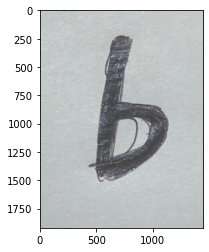

In [729]:
img = cv2.imread('my examples/example_3.jpg')
plt.imshow(img)

Негативация картинки:

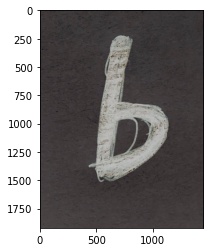

In [730]:
img = cv2.bitwise_not(img)
plt.imshow(img)

Перевод картинки в разрешение 28x28:

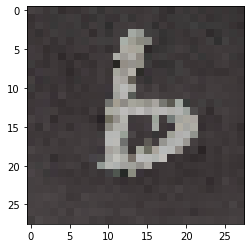

In [731]:
img = cv2.resize(img, (28, 28))
plt.imshow(img)

Сохранить измененную картинку:

In [736]:
cv2.imwrite('my examples/b/example_tuned.jpg', img)

True

In [739]:
image_dataset = datasets.ImageFolder(root='my examples/', transform=data_transforms['train'])

In [740]:
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=4, shuffle=True, num_workers=4)

In [750]:
with torch.no_grad():
    inputs, labels = next(iter(dataloader))
    inputs = (inputs.view(inputs.shape[0], -1)).to(device)
    outputs = model1(inputs)
    _, predicted = torch.max(outputs, 1)
    print(predicted[0])

tensor(7, device='cuda:0')


Видим, что модель предсказывает 7 лейбел, а он соответствует букве "h", которая довольно похожа на "b", соответственно, считаю эксперимент успешно выполненным

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html).

In [12]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 26)
model_ft = model_ft.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}

data_dir = 'images/' 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

In [17]:
model_ft = train_model_2(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 1)

Epoch 0/0
----------
train Loss: 2.6832 Acc: 0.2258
test Loss: 1.6153 Acc: 0.4882

Training complete in 7m 50s
Best test Acc: 0.488154


Видно, что сеть не успела подстроитья конкретно для нашей задачи, для этого следует запустить обучение на нескольких эпохах, но также следует отметить, что этот процесс занимает на порядок больше времени, чем обучение на простых нейронных сетях (почти 8 миинут, когда остальные модели учились в среднеи по 1.5 минуты)

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.

In [7]:
from torch.utils.tensorboard import SummaryWriter

wirter_test = SummaryWriter('runs/test')
writer_train = SummaryWriter('runs/train')

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}

data_dir = 'images/' 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

In [11]:
def train_model_3(model, criterion, optimizer):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mod
        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs = (inputs.view(inputs.shape[0], -1)).to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs).to(device)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            # statistics
            running_loss += loss.item()
            running_corrects += (preds == labels).sum().item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if (i + 1) % 100 == 0:
                if phase == 'train':
                    writer_train.add_scalar('train loss', running_loss / 100, len(dataloaders[phase]) + i)
                    writer_train.add_scalar('train accuracy', epoch_acc / 100, len(dataloaders[phase]) + i)
                else:
                    wirter_test.add_scalar('train loss', running_loss / 100, len(dataloaders[phase]) + i)
                    wirter_test.add_scalar('train accuracy', epoch_acc / 100, len(dataloaders[phase]) + i)

                running_loss = 0.0
                running_corrects = 0

In [12]:
train_model_3(net1, nn.CrossEntropyLoss(), optimizer_1)

In [33]:
from IPython.display import Image

##### train:

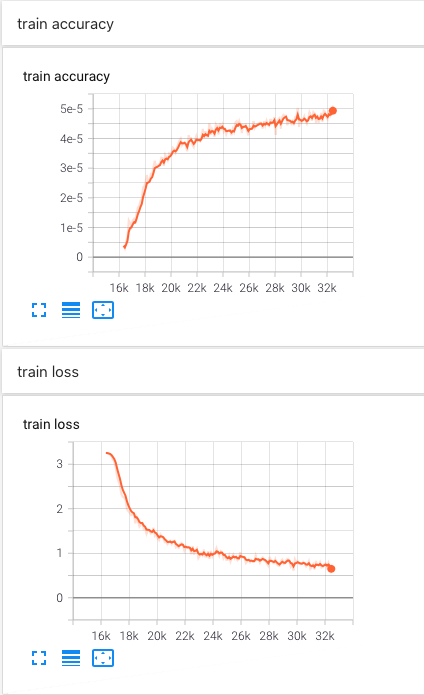

In [34]:
Image('runs/train.png')

##### test:

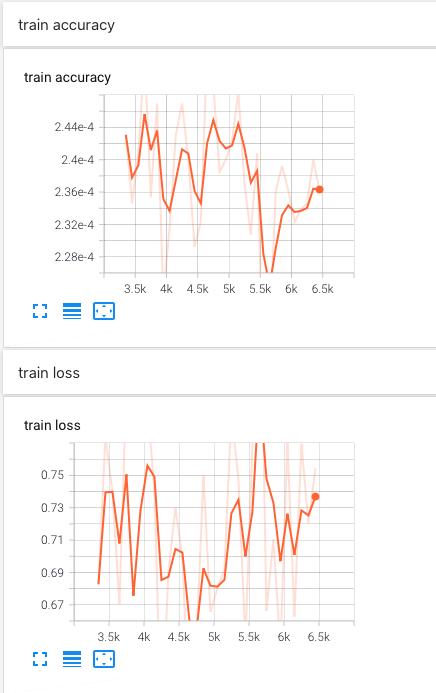

In [35]:
Image('runs/test.png')